In [2]:
import torch
import numpy as np
from draw import easy_draw
def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    将源域数据和目标域数据转化为核矩阵，即上文中的K
    Params: 
	    source: 源域数据（n * len(x))
	    target: 目标域数据（m * len(y))
	    kernel_mul: 
	    kernel_num: 取不同高斯核的数量
	    fix_sigma: 不同高斯核的sigma值
	Return:
		sum(kernel_val): 多个核矩阵之和
    '''
    n_samples = int(source.size()[0])+int(target.size()[0])# 求矩阵的行数，一般source和target的尺度是一样的，这样便于计算
    total = torch.cat([source, target], dim=0)#将source,target按列方向合并
    #将total复制（n+m）份
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #将total的每一行都复制成（n+m）行，即每个数据都扩展成（n+m）份
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    #求任意两个数据之间的和，得到的矩阵中坐标（i,j）代表total中第i行数据和第j行数据之间的l2 distance(i==j时为0）
    L2_distance = ((total0-total1)**2).sum(2) 
    #调整高斯核函数的sigma值
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    #以fix_sigma为中值，以kernel_mul为倍数取kernel_num个bandwidth值（比如fix_sigma为1时，得到[0.25,0.5,1,2,4]
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    #高斯核函数的数学表达式
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    #得到最终的核矩阵
    return sum(kernel_val)#/len(kernel_val)
 
def mmd_rbf(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    '''
    计算源域数据和目标域数据的MMD距离
    Params: 
	    source: 源域数据（n * len(x))
	    target: 目标域数据（m * len(y))
	    kernel_mul: 
	    kernel_num: 取不同高斯核的数量
	    fix_sigma: 不同高斯核的sigma值
	Return:
		loss: MMD loss
    '''
    
    batch_size = source.size()[0]#一般默认为源域和目标域的batchsize相同
    kernels = guassian_kernel(source, target,
        kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    #根据式（3）将核矩阵分成4部分
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    YX = kernels[batch_size:, :batch_size]
    loss = torch.mean(XX + YY - XY -YX)
    return loss.numpy() #因为一般都是n==m，所以L矩阵一般不加入计算

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
data_root   = 'F:\\graduate_student\\T2_GANpropeller\\test2\\1_model\\grid_mesh\\'
geom_list = np.load(data_root + 'mesh_data_test_modified.npy')
print(geom_list.shape)
ffd = np.load('data_set/complicated_ffd.npy')
# ffd = np.load('data_set/complicated_ffdmesh.npy')
ffdgan = np.load('data_set/complicated_FFDGAN.npy')
print(ffd.shape,ffdgan.shape)

(3634, 18, 68, 3)
(512, 18, 68, 3) (512, 18, 68, 3)


In [5]:
import random

def get_mmd(real,fake_ffd,p=100,num = 10):
    s_ffd = []
    real = real.reshape(real.shape[0],-1)
    fake_ffd = fake_ffd.reshape(fake_ffd.shape[0],-1)

    for i in range(num):
    
        a1 = random.sample(range(1,real.shape[0]),p)
        a2 = random.sample(range(1,fake_ffd.shape[0]),p)
        
        d1 = real[a1,:]
        d2 = fake_ffd[a2,:]
        
        s_ffd.append(mmd_rbf(d1,d2))

    s_ffd = np.array(s_ffd)
    return s_ffd

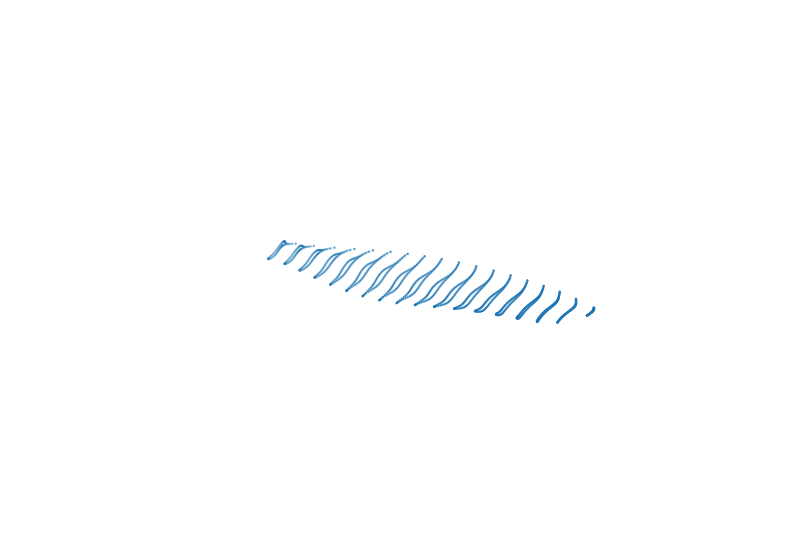

In [35]:
easy_draw(ffd[250])

In [10]:
real_mesh = torch.from_numpy(geom_list)
fake_ffd  = torch.from_numpy(ffd)
s1=get_mmd(real_mesh,fake_ffd)
print(np.mean(s1),np.std(s1))

0.35389522783556127 0.056102865325415384


In [40]:
fake_ffdgan  = torch.from_numpy(ffdgan)
s1=get_mmd(real_mesh,fake_ffdgan,100,100)
print(np.mean(s1),np.std(s1))

0.07564472010621298 0.02591260945870153


In [16]:
pcaGAN = np.load('data_set/complicated_ffdpca copy.npy')
pcaGAN = pcaGAN.reshape(pcaGAN.shape[0]*pcaGAN.shape[1],-1)
fake_pcaGAN = torch.from_numpy(pcaGAN)
s1=get_mmd(real_mesh,fake_pcaGAN,100,10)
print(np.mean(s1),np.std(s1))

0.21941601841835562 0.022170111383696386


In [79]:
# easy_draw(pcaGAN[600].reshape(18,68,3))
# easy_draw(pcaGAN[601].reshape(18,68,3))
# easy_draw(pcaGAN[602].reshape(18,68,3))

print(np.mean(np.abs(pcaGAN[601] - pcaGAN[600])),np.mean(np.abs(pcaGAN[602] - pcaGAN[600])))

0.0010658415398155901 0.0008249906389880042


In [102]:
pca = np.load('data_set/complicated_ffdpca.npy')
pca = pca.reshape(pca.shape[0],-1)
fake_pca = torch.from_numpy(pca)
s1=get_mmd(real_mesh,fake_pca,100,10)
print(np.mean(s1),np.std(s1))

0.4504364588212466 0.06887293996771222
